In [1]:
# !pip install keras

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import defaultdict
import os

In [3]:
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data directories
dataset_dir = 'data\\Mosquito-on-human-skin\\'
train_dir = os.path.join(dataset_dir, 'data_splitting/Train')
test_dir = os.path.join(dataset_dir, 'data_splitting/Test')

# Get class names
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")

Using device: cuda
Classes: ['Culex landing', 'Culex smashed', 'aegypti landing', 'aegypti smashed', 'albopictus landing', 'albopictus smashed']
Number of classes: 6


In [4]:
# Data transforms for MobileNet (224x224 input)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)), #reszie all images to standard MobileNet input size
    transforms.RandomHorizontalFlip(p=0.5), #50% prob to flip images horizontally
    transforms.RandomVerticalFlip(p=0.3), #30% probability to flip images vertically
    transforms.RandomRotation(degrees=10), #Slightly rotates images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #Randomly adjusts brightness, dcontrast, saturation and hue
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #Using ImageNet's mean and standard deviation to standardize pixel values
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
trainset = datasets.ImageFolder(root=train_dir, transform=transform_train)
testset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# Split training data into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])
#split training set into 80% training and 20% validation

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")

Training samples: 3360
Validation samples: 840
Test samples: 1799


In [5]:
# Custom MobileNet Implementation from Scratch

class DepthwiseSeparableConv(nn.Module):
    """
    Depthwise Separable Convolution: Key innovation of MobileNet
    Replaces standard convolution with depthwise + pointwise convolutions
    Reduces parameters and computations significantly
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        
        # Depthwise convolution: applies a 3x3 filter per input channel
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, 
            kernel_size=3, stride=stride, padding=1, 
            groups=in_channels, bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        # Pointwise convolution: 1x1 convolution to combine features
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, 
            kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        # Depthwise convolution
        x = self.depthwise(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Pointwise convolution
        x = self.pointwise(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        return x

In [6]:
class MobileNet(nn.Module):
    """
    Complete MobileNet Implementation from Scratch
    
    MobileNet uses depthwise separable convolutions to build light weight deep neural networks.
    Architecture follows the original MobileNet v1 paper.
    """
    def __init__(self, num_classes=6, width_multiplier=1.0):
        super(MobileNet, self).__init__()
        
        # First standard 3x3 convolution layer: 3 input channels to 32 output channels
        self.conv1 = nn.Conv2d(3, int(32 * width_multiplier), kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(int(32 * width_multiplier))
        
        # Depthwise separable convolution layers (core of MobileNet)： 13layers
        self.layers = nn.ModuleList([
            # (in_channels, out_channels, stride)
            DepthwiseSeparableConv(int(32 * width_multiplier), int(64 * width_multiplier), 1),
            DepthwiseSeparableConv(int(64 * width_multiplier), int(128 * width_multiplier), 2),
            DepthwiseSeparableConv(int(128 * width_multiplier), int(128 * width_multiplier), 1),
            DepthwiseSeparableConv(int(128 * width_multiplier), int(256 * width_multiplier), 2),
            DepthwiseSeparableConv(int(256 * width_multiplier), int(256 * width_multiplier), 1),
            DepthwiseSeparableConv(int(256 * width_multiplier), int(512 * width_multiplier), 2),
            
            # 5 layers with 512 filters
            DepthwiseSeparableConv(int(512 * width_multiplier), int(512 * width_multiplier), 1),
            DepthwiseSeparableConv(int(512 * width_multiplier), int(512 * width_multiplier), 1),
            DepthwiseSeparableConv(int(512 * width_multiplier), int(512 * width_multiplier), 1),
            DepthwiseSeparableConv(int(512 * width_multiplier), int(512 * width_multiplier), 1),
            DepthwiseSeparableConv(int(512 * width_multiplier), int(512 * width_multiplier), 1),
            
            DepthwiseSeparableConv(int(512 * width_multiplier), int(1024 * width_multiplier), 2),
            DepthwiseSeparableConv(int(1024 * width_multiplier), int(1024 * width_multiplier), 1),
        ])
        
        # Global average pooling and classifier: 20% dropout for regularization, a linear layer for classification(1024 -> num_classes)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(int(1024 * width_multiplier), num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # First standard convolution
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Depthwise separable convolutions
        for layer in self.layers:
            x = layer(x)
        
        # Global average pooling and classification
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# Create model instance
model = MobileNet(num_classes=num_classes, width_multiplier=1.0).to(device)

# Test the model
test_input = torch.randn(1, 3, 224, 224).to(device)
test_output = model(test_input)
print(f"Model output shape: {test_output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * 4 for p in model.parameters()) / (1024**2):.1f} MB")

Model output shape: torch.Size([1, 6])
Number of parameters: 3,213,126
Model size: 12.3 MB


In [7]:
# Training setup
criterion = nn.CrossEntropyLoss() #Combines LogSoftmax and Negative Log-Likelihood loss
#Converts model logits to probabilities and computes the negative log-likelihood of the true class, penalizing incorrect predictions.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model performance"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_mobilenet(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    """Train the MobileNet model"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 50)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_mobilenet_mosquito.pth')
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [8]:
# Train the custom MobileNet model
num_epochs = 25
print("Starting Custom MobileNet Training...")
print(f"Training for {num_epochs} epochs")
print(f"Class names: {class_names}")
print("=" * 60)

train_losses, val_losses, train_accuracies, val_accuracies = train_mobilenet(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
)

Starting Custom MobileNet Training...
Training for 25 epochs
Class names: ['Culex landing', 'Culex smashed', 'aegypti landing', 'aegypti smashed', 'albopictus landing', 'albopictus smashed']
Epoch 1/25, Batch 0/105, Loss: 1.8036
Epoch 1/25, Batch 20/105, Loss: 1.7575
Epoch 1/25, Batch 40/105, Loss: 1.8166
Epoch 1/25, Batch 60/105, Loss: 1.4372
Epoch 1/25, Batch 80/105, Loss: 1.5141
Epoch 1/25, Batch 100/105, Loss: 1.5139
Epoch 1/25:
  Train Loss: 1.6467, Train Acc: 30.33%
  Val Loss: 2.1415, Val Acc: 27.74%
  Learning Rate: 0.001000
--------------------------------------------------
New best model saved with validation accuracy: 27.74%
Epoch 2/25, Batch 0/105, Loss: 1.4480
Epoch 2/25, Batch 20/105, Loss: 1.2489
Epoch 2/25, Batch 40/105, Loss: 1.6062
Epoch 2/25, Batch 60/105, Loss: 1.3646
Epoch 2/25, Batch 80/105, Loss: 1.2508
Epoch 2/25, Batch 100/105, Loss: 0.8222
Epoch 2/25:
  Train Loss: 1.2646, Train Acc: 49.73%
  Val Loss: 1.5394, Val Acc: 45.95%
  Learning Rate: 0.001000
--------

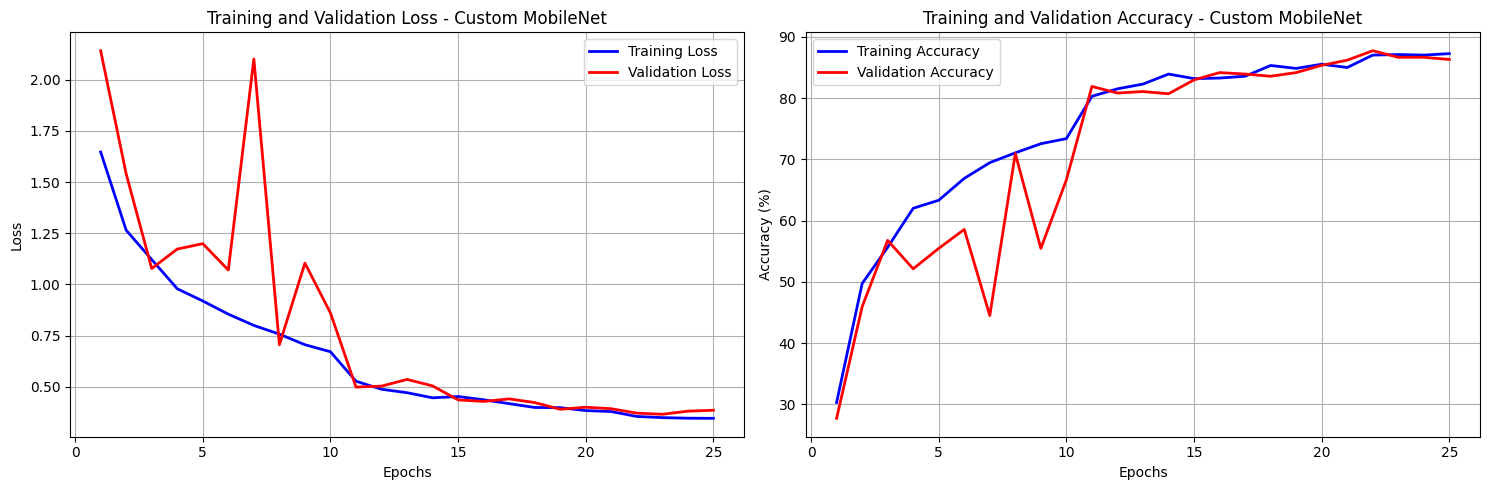

In [9]:
# Plot training curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training and validation curves"""
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss - Custom MobileNet')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy - Custom MobileNet')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [10]:
# Comprehensive testing function
def test_mobilenet(model, test_loader, criterion, device, class_names):
    """Test the MobileNet model comprehensively"""
    model.eval()
    correct = 0
    total = 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    all_preds = []
    all_labels = []
    correct_images = {}
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Per-class accuracy and correct images
            for img, label, pred in zip(images, labels, predicted):
                class_total[label.item()] += 1
                if label == pred:
                    class_correct[label.item()] += 1
                    # Store first correct prediction for each class
                    if label.item() not in correct_images:
                        correct_images[label.item()] = (img.cpu(), class_names[label.item()])
    
    # Overall accuracy
    overall_accuracy = 100 * correct / total
    print(f'MobileNet Test Accuracy: {overall_accuracy:.2f}%')
    print()
    
    # Per-class accuracy
    print('Per-class Accuracy:')
    for i in range(len(class_names)):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            print(f'{class_names[i]}: {class_acc:.2f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'{class_names[i]}: No samples')
    
    return correct_images, all_labels, all_preds, overall_accuracy

# Test the model
correct_images, all_labels, all_preds, test_accuracy = test_mobilenet(model, test_loader, criterion, device, class_names)

MobileNet Test Accuracy: 87.88%

Per-class Accuracy:
Culex landing: 96.00% (288/300)
Culex smashed: 96.67% (290/300)
aegypti landing: 88.00% (264/300)
aegypti smashed: 73.33% (220/300)
albopictus landing: 85.95% (257/299)
albopictus smashed: 87.33% (262/300)



CUSTOM MOBILENET RESULTS


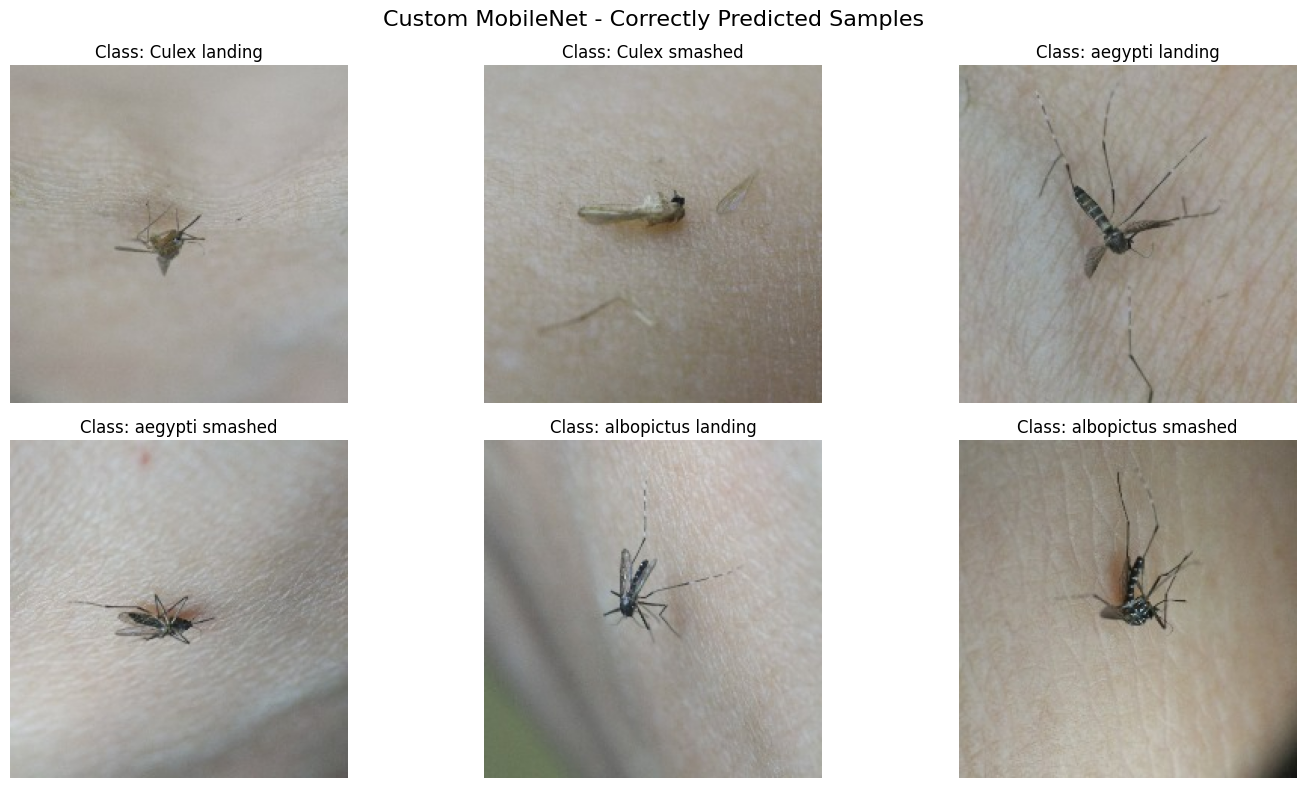

In [11]:
# Visualization functions
def plot_correct_predictions(correct_images, class_names):
    """Plot correctly predicted images for each class"""
    plt.figure(figsize=(15, 8))
    
    for i, (label_idx, (img, label_name)) in enumerate(correct_images.items()):
        plt.subplot(2, 3, i + 1)
        
        # Denormalize the image for display
        img_denorm = img.clone()
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        for t, m, s in zip(img_denorm, mean, std):
            t.mul_(s).add_(m)
        img_denorm = torch.clamp(img_denorm, 0, 1)
        
        # Convert to numpy and transpose for matplotlib
        img_np = img_denorm.permute(1, 2, 0).numpy()
        
        plt.imshow(img_np)
        plt.title(f'Class: {label_name}', fontsize=12)
        plt.axis('off')
    
    plt.suptitle('Custom MobileNet - Correctly Predicted Samples', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_custom(all_labels, all_preds, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    plt.figure(figsize=(10, 8))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix - Custom MobileNet", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Display results
print("\n" + "="*60)
print("CUSTOM MOBILENET RESULTS")
print("="*60)

plot_correct_predictions(correct_images, class_names)

<Figure size 1000x800 with 0 Axes>

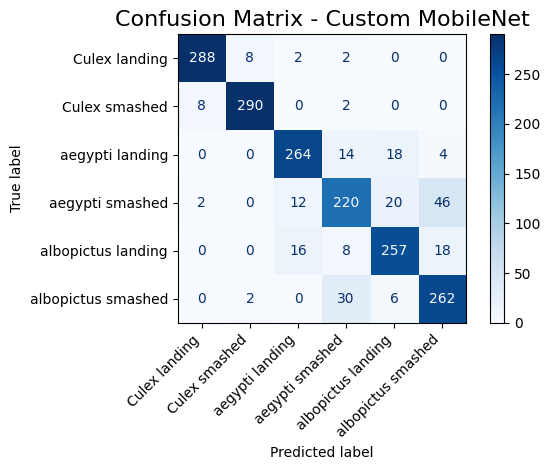


CUSTOM MOBILENET ANALYSIS
Test Accuracy: 87.88%
Number of parameters: 3,213,126
Model size: 12.3 MB

MobileNet Architecture Features:
✓ Depthwise Separable Convolutions
✓ Significant parameter reduction vs standard CNNs
✓ Efficient for mobile and edge devices
✓ Global Average Pooling instead of fully connected layers
✓ Width multiplier for model scaling

Final model saved as 'final_mobilenet_mosquito.pth'


In [12]:
# Display confusion matrix
plot_confusion_matrix_custom(all_labels, all_preds, class_names)

# Model summary and analysis
print("\n" + "="*60)
print("CUSTOM MOBILENET ANALYSIS")
print("="*60)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * 4 for p in model.parameters()) / (1024**2):.1f} MB")

print("\nMobileNet Architecture Features:")
print("✓ Depthwise Separable Convolutions")
print("✓ Significant parameter reduction vs standard CNNs")
print("✓ Efficient for mobile and edge devices")
print("✓ Global Average Pooling instead of fully connected layers")
print("✓ Width multiplier for model scaling")

# Save the final model
torch.save(model.state_dict(), 'final_mobilenet_mosquito.pth')
print("\nFinal model saved as 'final_mobilenet_mosquito.pth'")

In [13]:
# Detailed classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=1))

# Compare with other architectures
print("\n" + "="*60)
print("ARCHITECTURE COMPARISON")
print("="*60)
print("MobileNet vs Standard CNN vs ResNet-50:")
print()
print("MobileNet:")
print("- Uses depthwise separable convolutions")
print("- ~4M parameters (lightweight)")
print("- Designed for mobile/edge deployment")
print("- Fast inference time")
print()
print("Standard CNN (from 9444ass2):")
print("- Traditional convolutions")
print("- ~500K parameters (simplest)")
print("- Basic architecture")
print("- Good for learning/prototyping")
print()
print("ResNet-50:")
print("- Residual connections")
print("- ~23M parameters (heaviest)")
print("- Deep architecture (50 layers)")
print("- High accuracy but computationally intensive")


DETAILED CLASSIFICATION REPORT
                    precision    recall  f1-score   support

     Culex landing       0.97      0.96      0.96       300
     Culex smashed       0.97      0.97      0.97       300
   aegypti landing       0.90      0.88      0.89       300
   aegypti smashed       0.80      0.73      0.76       300
albopictus landing       0.85      0.86      0.86       299
albopictus smashed       0.79      0.87      0.83       300

          accuracy                           0.88      1799
         macro avg       0.88      0.88      0.88      1799
      weighted avg       0.88      0.88      0.88      1799


ARCHITECTURE COMPARISON
MobileNet vs Standard CNN vs ResNet-50:

MobileNet:
- Uses depthwise separable convolutions
- ~4M parameters (lightweight)
- Designed for mobile/edge deployment
- Fast inference time

Standard CNN (from 9444ass2):
- Traditional convolutions
- ~500K parameters (simplest)
- Basic architecture
- Good for learning/prototyping

ResNet-50:
- Re

In [14]:
# MobileNet Efficiency Analysis
print("\n" + "="*60)
print("MOBILENET EFFICIENCY ANALYSIS")
print("="*60)

# Calculate computational efficiency
def calculate_flops_approximate(model, input_size=(1, 3, 224, 224)):
    """Approximate FLOP calculation for comparison"""
    total_params = sum(p.numel() for p in model.parameters())
    # Rough approximation: 2 FLOPs per parameter for forward pass
    approx_flops = total_params * 2 * input_size[2] * input_size[3] / (1000**3)  # GFLOPs
    return approx_flops

approx_flops = calculate_flops_approximate(model)
param_count = sum(p.numel() for p in model.parameters())

print(f"Approximate computational cost: {approx_flops:.2f} GFLOPs")
print(f"Parameter efficiency: {test_accuracy/param_count*1000000:.2f} accuracy per million parameters")
print(f"Memory efficiency: {test_accuracy/(param_count*4/1024**2):.2f} accuracy per MB")

print("\nDepthwise Separable Convolution Benefits:")
print("- Reduces parameters by factor of 8-9x vs standard convolution")
print("- Reduces computation by similar factor")
print("- Maintains similar accuracy")
print("- Enables real-time inference on mobile devices")

print(f"\nCustom MobileNet Summary:")
print(f"- Implemented from scratch with PyTorch")
print(f"- Full control over architecture")
print(f"- Efficient depthwise separable convolutions")
print(f"- Suitable for deployment on resource-constrained devices")


MOBILENET EFFICIENCY ANALYSIS
Approximate computational cost: 322.44 GFLOPs
Parameter efficiency: 27.35 accuracy per million parameters
Memory efficiency: 7.17 accuracy per MB

Depthwise Separable Convolution Benefits:
- Reduces parameters by factor of 8-9x vs standard convolution
- Reduces computation by similar factor
- Maintains similar accuracy
- Enables real-time inference on mobile devices

Custom MobileNet Summary:
- Implemented from scratch with PyTorch
- Full control over architecture
- Efficient depthwise separable convolutions
- Suitable for deployment on resource-constrained devices


In [15]:
plt.figure()
plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.title('Train and val accuracy')
plt.legend(['Train accuracy','Val accuracy'],loc = 'lower right')
plt.show()

NameError: name 'epochs' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
predictions = model.evaluate(test_data)

29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 640ms/step - accuracy: 0.8820 - loss: 0.4106


29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 656ms/step


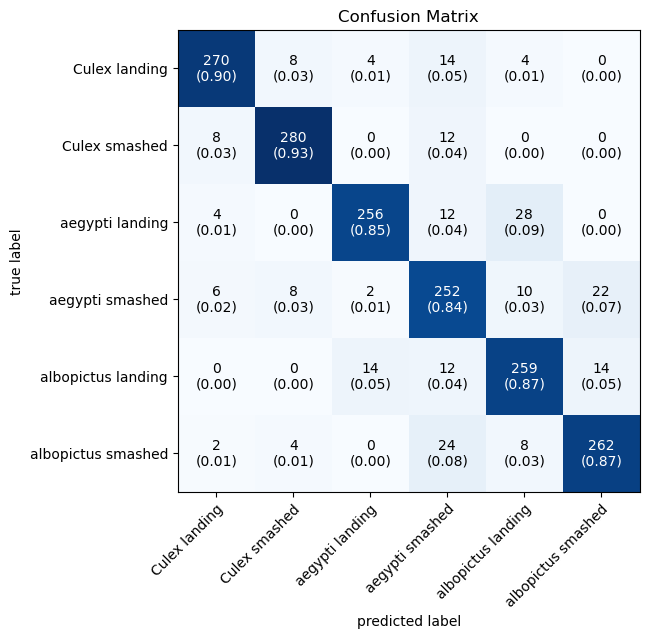

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

true_labels = []
for images, labels in test_data:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
true_labels = np.array(true_labels)

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(true_labels, y_pred_classes)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix,
    figsize=(8, 6),
    class_names=class_names,
    show_normed=True,
    cmap='Blues'
)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, y_pred_classes, target_names=class_names, zero_division=1))

                    precision    recall  f1-score   support

     Culex landing       0.93      0.90      0.92       300
     Culex smashed       0.93      0.93      0.93       300
   aegypti landing       0.93      0.85      0.89       300
   aegypti smashed       0.77      0.84      0.81       300
albopictus landing       0.84      0.87      0.85       299
albopictus smashed       0.88      0.87      0.88       300

          accuracy                           0.88      1799
         macro avg       0.88      0.88      0.88      1799
      weighted avg       0.88      0.88      0.88      1799

